# Script para calcular el missing money para un escenario 

Llamar las librerías

In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Definición de colores

In [339]:
tech_colors = {
    'Bomb': 'blue',
    'CAES': 'purple',
    'CSP-TES': 'orange',
    'ESS': 'hotpink',
    'HYDRO': 'deepskyblue',
    'PV': 'yellow',
    'TERMO': 'brown',
    'TES': 'red',
    'WIND': 'green',
}

Definición de diccionarios

In [340]:
#[$/kW/mes]

map_pncp_bar_loadzone_bar = {
    "loschangos": "CALAMA",
    "nuevapozoalmonte": "TARAPACA",
    "parinacota": "PARINACOTA",
    "lagunas": "TARAPACA",
    "arica": "PARINACOTA",
    "tarapaca": "TARAPACA",
    "coquimbo": "PANDEAZUCAR",
    "atacama": "ATACAMA",
    "valparaiso": "QUILLOTA",
}

PNCP_jul_24={
    "PARINACOTA":9307.94, #Arica
    "POZOALMONTE":8980.87,
    "CONDORES":9035.92,
    "TARAPACA":8860.24, #Tarapaca
    "LAGUNAS":8785.75,
    "NUEVAVICTORIA":8750.94,
    "CRUCERO":8447.34,
    "ENCUENTRO":8465.96,
    "CHUQUICAMATA":8508.06,
    "CALAMA":8517.78,
    "ELTESORO":8479.73,
    "ESPERANZASING":8478.11,
    "ATACAMA":8329.14,
    "ELCOBRE":8402.00,
    "LABERINTO":8444.10,
    "OHIGGINS":8457.06,
    "DDEALMAGRO":8372.05,
    "CARRERAPINTO":8307.28,
    "CARDONES":8267.61,
    "MAITENCILLO":8044.97,
    "PUNTACOLORADA":8030.40,
    "PANDEAZUCAR":8134.84,
    "LOSVILOS":8058.74,
    "NOGALES":8095.98,
    "QUILLOTA":8016.64,
    "POLPAICO":8018.26,
    "ELLLANO":8054.69,
    "LOSMAQUIS":8075.74,
    "LAMPA":7734.90,
    "CERRONAVIA":8039.31,
    "MELIPILLA":7994.78,
    "RAPEL":7907.34,
    "CHENA":8030.40,
    "MAIPO":7875.77,
    "ALTOJAHUEL":7879.81,
    "ITAHUE":7075.07,
    "ANCOA":6974.68,
    "CHARRUA":6782.81,
    "COLBUN":6974.68,
    "CANDELARIA":7735.71,
    "HUALPEN":7014.35,
    "LAGUNILLAS":7009.50,
    "CAUTÍN":5983.74,
    "TEMUCO":6000.74,
    "CIRUELOS":7981.04,
    "VALDIVIA":7925.62,
    "RAHUE":7536.97,
    "PUERTOMONTT":7590.87,
    "MELIPULLI":7590.87,
    "CHILOE":7676.64,
}

potencia_recocida = {
    1: 0.36,
    2: 0.65,
    3: 0.85,
    4: 0.98,
    5: 1.00,
}

Definición de url

In [341]:
use_monthly_aggregation = False #True, lo divide en meses, False, lo deja anual
time_key_for_plot = 'month' if use_monthly_aggregation == True else 'year'
discount_rate = 0.07

# base_route = "C:\Users\maty_\Desktop\Magister\Tesis\Scripts"
base_route = "C:/Users/Ignac/Trabajo_Centra/Catedra-LDES/CII-Centra-EDF/Operacion"
# study_case = "Modelos_SEN_finals/EEN 1 EEC 1 (Transicion Acelerada)"
study_case = "escenarios/CaseBase1/CN"
# study_case = "Modelos_SEN_finals/EEN -1 EEC -1 (Recuperacion Lenta)"
inputs_path = "inputs_opp"
outputs_path = "outputs"

periods = [2029, 2030, 2031, 2033, 2040, 2050]

technologies_interest = ["Bomb", "CSP-TES", "TES", "CAES"]

Lectura de archivos consolidados de resultados

In [342]:
# Cada consolidado de resultados corresponde a un year tipo para su periodo correspondiente, por lo que no es necesario escalar mas que por la cantidad de years

period_results = []
for period in periods:
    file_path = fr'{base_route}\{study_case}\{outputs_path}\battery_operational_results_{period}.csv'
    base_data = pd.read_csv(file_path)
    base_data["PERIOD"] = period
    period_results.append(base_data)
data = pd.concat(period_results, ignore_index=True)
file_path_periods = fr'{base_route}\{study_case}\{inputs_path}\periods.csv'
periods_data = pd.read_csv(file_path_periods)
file_path_gen_build_costs = fr'{base_route}\{study_case}\{inputs_path}\gen_build_costs.csv'
gen_build_costs_data = pd.read_csv(file_path_gen_build_costs)
file_path_gen_build = fr'{base_route}\{study_case}\{outputs_path}\gen_build.csv'
gen_build_data = pd.read_csv(file_path_gen_build)
file_path_gen_cap = fr'{base_route}\{study_case}\{outputs_path}\gen_cap.csv'
gen_cap_data = pd.read_csv(file_path_gen_cap)
file_path_gen_info = fr'{base_route}\{study_case}\{inputs_path}\gen_info.csv'
gen_info_data = pd.read_csv(file_path_gen_info)
gen_info_data

,GENERATION_PROJECT,gen_tech,gen_load_zone,gen_connect_cost_per_mw,gen_capacity_limit_mw,gen_full_load_heat_rate,gen_variable_om,gen_max_age,gen_min_build_capacity,gen_scheduled_outage_rate,...,gen_tes_powerblock_eff,gen_tes_duration,gen_can_provide_cap_reserves,csp_tes_capacity_upper_mwht,csp_sf_tes_efficiency,csp_tes_efficiency,csp_tes_pb_efficiency,csp_sf_tes_pb_efficiency,csp_pb_efficiency,peak_demand_gen_max_percent
0,Ancali1,TERMO,Gxnode-Ancali1-Bio Bio_2,0.0,1.56,1.992,0.000,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
1,Copiulemu,TERMO,Gxnode-Copiulemu-Bio Bio_2,0.0,0.99,0.243,25.200,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
2,ElCampesino,TERMO,Gxnode-ElCampesino-Metropolitana de Santiago_2,0.0,1.59,1.992,22.786,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
3,ElMolle,TERMO,Gxnode-ElMolle-Valparaiso,0.0,4.50,0.25,18.197,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
4,HBS,TERMO,Gxnode-HBS-Bio Bio_2,0.0,2.20,0.26,6.940,70,0,0.000000,...,.,.,0,.,.,.,.,.,.,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502,BESS Víctor Jara,ESS,Tarapaca_2,0.0,200.00,.,0.000,30,0,0.032877,...,.,.,5,.,.,.,.,.,.,1.00
1503,BESS Huatacondo,ESS,Tarapaca,0.0,98.00,.,0.000,30,0,0.032877,...,.,.,1,.,.,.,.,.,.,0.81
1504,BESS Livorno,ESS,Valparaiso,0.0,5.00,.,0.000,30,0,0.032877,...,.,.,5,.,.,.,.,.,.,1.00
1505,BESS San Marcos,ESS,Arica y Parinacota,0.0,2.90,.,0.000,30,0,0.032877,...,.,.,1,.,.,.,.,.,.,0.81


Trabajo sobre dataframe periods_data

In [343]:
periods_data["period_duration_years"] = periods_data["period_end"] - periods_data["period_start"]
periods_data = periods_data.rename(columns={"INVESTMENT_PERIOD": "PERIOD"})
periods_data

,PERIOD,period_start,period_end,period_duration_years
0,2024,2024,2026,2
1,2026,2026,2029,3
2,2029,2029,2030,1
3,2030,2030,2031,1
4,2031,2031,2033,2
5,2033,2033,2040,7
6,2040,2040,2050,10
7,2050,2050,2060,10


Filtrado de dataframes filtered_cost, filtered_gen_build y filtered_gen_cap

In [344]:
# Step 2: Filter by the specific project
generation_projects_of_interest = list(set(data["generation_project"]))
# project_name = "Bomb_Tarapaca2_10h"
# filtered_data = data[data['generation_project'] == project_name].copy()
filtered_cost = gen_build_costs_data[(gen_build_costs_data["gen_overnight_cost"] != 0)].copy()
filtered_cost = filtered_cost.rename(columns={"build_year": "PERIOD"})
filtered_gen_build = gen_build_data[gen_build_data["GENERATION_PROJECT"].isin(generation_projects_of_interest)].copy()
filteder_gen_cap = gen_cap_data[gen_cap_data["GENERATION_PROJECT"].isin(generation_projects_of_interest)][["GENERATION_PROJECT", "PERIOD", "GenCapacity"]].copy()
filteder_gen_cap

,GENERATION_PROJECT,PERIOD,GenCapacity
80,ANDES IV SOLAR FOTOVOLTAICO BESS,2024,0.000
81,ANDES IV SOLAR FOTOVOLTAICO BESS,2026,130.000
82,ANDES IV SOLAR FOTOVOLTAICO BESS,2029,130.000
83,ANDES IV SOLAR FOTOVOLTAICO BESS,2030,130.000
84,ANDES IV SOLAR FOTOVOLTAICO BESS,2031,130.000
...,...,...,...
11435,TES_Parinacota220_250_6h,2030,0.000
11436,TES_Parinacota220_250_6h,2031,0.000
11437,TES_Parinacota220_250_6h,2033,0.000
11438,TES_Parinacota220_250_6h,2040,0.000


Ajuste para proyectos TES

In [345]:
#Ajuste para proyectos TES que tienen duracion en columna distinta
gen_info_data.loc[gen_info_data['gen_tech'] == 'TES', 'gen_storage_energy_to_power_ratio'] = gen_info_data['gen_tes_duration']
gen_info_data_filtered = gen_info_data[["GENERATION_PROJECT", "gen_storage_energy_to_power_ratio", "gen_tech"]][gen_info_data["GENERATION_PROJECT"].isin(generation_projects_of_interest)].copy()
gen_info_data_filtered["power_recognized"] = gen_info_data_filtered.apply(lambda row: potencia_recocida.get(int(row['gen_storage_energy_to_power_ratio']), 1), axis=1).fillna(1).astype(float)
gen_info_data_filtered = gen_info_data_filtered.rename(columns={"GENERATION_PROJECT": "generation_project"})

Calculo costos por generador a valor presente al 2024

In [346]:
# Asume que el archivo CSV está en la ruta especificada
file_path_gen_annual_summary = fr'{base_route}\{study_case}\{outputs_path}\dispatch_gen_annual_summary.csv'
df = pd.read_csv(file_path_gen_annual_summary)

generators = df['generation_project'].unique()

def calculate_present_value(future_value, discount_rate, years):
    return future_value / ((1 + discount_rate) ** years)

def calculate_annuity_value(payment, discount_rate, periods):
    return (1 - (1 + discount_rate) ** -periods) / discount_rate * payment

# Define the periods of investment
investment_periods = {
    2024: 3,
    2026: 3,
    2029: 1,
    2030: 1,
    2031: 2,
    2033: 7,
    2040: 10,
    2050: 10
}

# Initialize a dictionary to store the NPV for each energy source
npv_dict = {}
gens_tec_dict = {}

# Iterate over each unique energy source
for gen in generators:
    # Filter the DataFrame for the current energy source
    df_filtered = df[df['generation_project'] == gen]

    # Initialize the total NPV for the current energy source
    total_npv = 0.0

    # Iterate over each row in the filtered DataFrame
    for index, row in df_filtered.iterrows():
        period = row['period']
        gen_capital_costs = row['GenCapitalCosts']
        gen_fixed_om_costs = row['GenFixedOMCosts']

        # Calculate the annuity value at the start of the investment period for GenCapitalCosts
        annuity_value_capital = calculate_annuity_value(gen_capital_costs, discount_rate, investment_periods.get(period, 0))

        # Calculate the annuity value at the start of the investment period for GenFixedOMCosts
        annuity_value_fixed_om = calculate_annuity_value(gen_fixed_om_costs, discount_rate, investment_periods.get(period, 0))

        # Calculate the present value of the annuity value at the base year (2024) for GenCapitalCosts
        present_value_capital = calculate_present_value(annuity_value_capital, discount_rate, period - 2024)

        # Calculate the present value of the annuity value at the base year (2024) for GenFixedOMCosts
        present_value_fixed_om = calculate_present_value(annuity_value_fixed_om, discount_rate, period - 2024)

        # Add the present values to the total NPV for the current energy source
        total_npv += present_value_capital + present_value_fixed_om

    # Store the total NPV for the current energy source in the dictionary
    npv_dict[gen] = total_npv
    if not df_filtered.empty and df_filtered['gen_energy_source'].iloc[0] in technologies_interest:
        gens_tec_dict[gen] = "LDES"
    else:
        gens_tec_dict[gen] = "OTHER"

# Filter npv_dict to only include generators where gens_tec_dict is "LDES"
ldes_npv_dict = {gen: npv for gen, npv in npv_dict.items() if gens_tec_dict.get(gen) == "LDES"}

# Filter ldes_npv_dict to only include generators where the NPV is not zero
non_zero_ldes_npv_dict = {gen: npv for gen, npv in ldes_npv_dict.items() if npv != 0}

print(npv_dict)
print("Diccionario de NPV para generadores LDES:")
print(ldes_npv_dict)
print("Diccionario de NPV no cero para generadores LDES:")
print(non_zero_ldes_npv_dict)

{'ABANICO': 0.0, 'ACIDOMEJILLONES': 0.0, 'AGUASBLANCAS': 0.0, 'AILLIN': 0.0, 'ALERCE': 0.0, 'ALFALFAL': 0.0, 'ALLIPEN': 0.0, 'ALTORENAICO': 0.0, 'ALTURASDEOVALLE': 0.0, 'AMPARODELSOL': 0.0, 'ANDES IV SOLAR FOTOVOLTAICO BESS': 0.0, 'ANDESSOLAR': 0.0, 'ATACAMA_CC1': 0.0, 'ATACAMA_CC2': 0.0, 'Aguas_Blancas_2': 0.0, 'Alcones': 0.0, 'Alena': 0.0, 'Alfa_Solar': 0.0, 'Alfalfal_2': 0.0, 'Alicahue': 0.0, 'Almendrado': 0.0, 'Almeyda': 0.0, 'Almonte': 0.0, 'AltoSolar': 0.0, 'AltosdelPaico': 0.0, 'Ampl_Finis_Terrae_I': 0.0, 'Ampl_Quilapilun': 0.0, 'Ancali1': 0.0, 'Ancoa': 0.0, 'Andes Solar IIA BaterÃ\xadas': 0.0, 'AndesGeneracion': 0.0, 'Andes_220_IV': 0.0, 'Andes_Solar_IIA': 0.0, 'Angostura': 0.0, 'AntilhueTG': 0.0, 'Antuco': 0.0, 'Arauco': 0.0, 'Arica_Solar': 0.0, 'Ariztia': 0.0, 'Arrayan': 0.0, "Asesorias D'E Capital SpA": 0.0, 'Atacama Solar I': 0.0, 'Atacama_Solar_II': 0.0, 'Aurora': 0.0, 'AuxiliardelMaipo': 0.0, 'BESS Alicanto': 0.0, 'BESS AmpliaciÃ³n BESS Parque EÃ³lico La CabaÃ±a': 0.0, 'B

Expansión de periods_data

In [347]:
df_periods_expanded = periods_data.loc[periods_data.index.repeat(periods_data['period_duration_years'])].reset_index(drop=True)
df_periods_expanded['year'] = df_periods_expanded['period_start'] + df_periods_expanded.groupby('period_start').cumcount()
df_periods_expanded

,PERIOD,period_start,period_end,period_duration_years,year
0,2024,2024,2026,2,2024
1,2024,2024,2026,2,2025
2,2026,2026,2029,3,2026
3,2026,2026,2029,3,2027
4,2026,2026,2029,3,2028
5,2029,2029,2030,1,2029
6,2030,2030,2031,1,2030
7,2031,2031,2033,2,2031
8,2031,2031,2033,2,2032
9,2033,2033,2040,7,2033


Join con periods_data

In [348]:
df_expanded_periods = pd.merge(
    data,
    df_periods_expanded[['period_start', 'year']],
    left_on='PERIOD',
    right_on='period_start',
    how='inner'
)
# df_expanded_periods['year'] = df_expanded_periods['year_y']
# df_expanded_periods['month'] = df_expanded_periods.apply(lambda row: pd.Period(year=row['year'], month=row['month'].month, freq='M'), axis=1)
# df_expanded_periods = df_expanded_periods.rename(columns={'year_x': 'PERIOD'})
df_expanded_periods = df_expanded_periods.drop(columns=['period_start']).sort_values(['year']).reset_index(drop=True)

df_expanded_periods = pd.merge(df_expanded_periods, periods_data, left_on="PERIOD", right_on="PERIOD", how="inner")


df_expanded_periods

,generation_project,total_charge_cost,total_discharge_earnings,PERIOD,year,period_start,period_end,period_duration_years
0,ANDES IV SOLAR FOTOVOLTAICO BESS,5.786500e+06,1.668248e+07,2029,2029,2029,2030,1
1,BESS San Andrés,1.594621e+06,4.815385e+06,2029,2029,2029,2030,1
2,BESS San Marcos,6.281442e+04,1.192276e+05,2029,2029,2029,2030,1
3,BESS Tamaya,2.707318e+06,9.266030e+06,2029,2029,2029,2030,1
4,BESS Tocopilla,4.338687e+06,1.388637e+07,2029,2029,2029,2030,1
...,...,...,...,...,...,...,...,...
1634,BESS Diego de Almagro Sur,5.557537e+05,1.145622e+06,2050,2059,2050,2060,10
1635,BESS Quillahua,1.766973e+06,3.621846e+06,2050,2059,2050,2060,10
1636,PFV Salvador,3.596441e+06,8.141629e+06,2050,2059,2050,2060,10
1637,BESS Coya,6.160335e+06,1.862399e+07,2050,2059,2050,2060,10


Trabajo previo a plot

In [349]:
aggregated_data = df_expanded_periods.groupby(["generation_project", time_key_for_plot]).agg({
    'PERIOD': 'max',
    'total_discharge_earnings': 'sum',
    'total_charge_cost': 'sum'
}).reset_index()

Se agregan luego los costos de OPEX y CAPEX para cada periodo

In [350]:
# aggregated_data["capex"] = aggregated_data["year"].map(consolidated_capex_cost_period_dict).fillna(0).astype(float)
# aggregated_data["opex"] = aggregated_data["PERIOD"].map(consolidated_opex_cost_period_dict).fillna(0).astype(float)
filteder_gen_cap = filteder_gen_cap.rename(columns={"GENERATION_PROJECT": "generation_project"})
aggregated_data = pd.merge(aggregated_data, filteder_gen_cap, on=['generation_project','PERIOD'], how='inner')
# aggregated_data["capex"] = aggregated_data.apply(lambda row: consolidated_capex_cost_period_dict.get((row['generation_project'], row['year']), None), axis=1).fillna(0).astype(float)
# aggregated_data["opex"] = aggregated_data.apply(lambda row: consolidated_opex_cost_period_dict.get((row['generation_project'], row['PERIOD']), None), axis=1).fillna(0).astype(float)
aggregated_data = pd.merge(aggregated_data, gen_info_data_filtered, on="generation_project", how="inner")

def map_bar_and_value(row):
    for keyword, bar_name in map_pncp_bar_loadzone_bar.items():
        if keyword in row['generation_project'].lower():
            return pd.Series({'bar_name': bar_name, 'pnpc_power_value': PNCP_jul_24.get(bar_name, PNCP_jul_24["NOGALES"])})
    return pd.Series({'bar_name': "NOGALES", 'pnpc_power_value': PNCP_jul_24["NOGALES"]})

aggregated_data[['bar_name', 'pnpc_power_value']] = aggregated_data.apply(map_bar_and_value, axis=1)

aggregated_data["yearly_power_income"] = aggregated_data["GenCapacity"]*aggregated_data["power_recognized"]*aggregated_data["pnpc_power_value"]*12

aggregated_data = aggregated_data[["generation_project", time_key_for_plot, "bar_name", "gen_tech", "gen_storage_energy_to_power_ratio", "total_discharge_earnings", "total_charge_cost", "yearly_power_income"]].copy()
aggregated_data[aggregated_data["gen_tech"] == "ESS"]

,generation_project,year,bar_name,gen_tech,gen_storage_energy_to_power_ratio,total_discharge_earnings,total_charge_cost,yearly_power_income
0,ANDES IV SOLAR FOTOVOLTAICO BESS,2029,NOGALES,ESS,5,1.668248e+07,5.786500e+06,1.262973e+07
1,ANDES IV SOLAR FOTOVOLTAICO BESS,2030,NOGALES,ESS,5,1.841846e+07,5.281661e+06,1.262973e+07
2,ANDES IV SOLAR FOTOVOLTAICO BESS,2031,NOGALES,ESS,5,1.935992e+07,3.870860e+06,1.262973e+07
3,ANDES IV SOLAR FOTOVOLTAICO BESS,2032,NOGALES,ESS,5,1.935992e+07,3.870860e+06,1.262973e+07
4,ANDES IV SOLAR FOTOVOLTAICO BESS,2033,NOGALES,ESS,5,1.996074e+07,5.300682e+06,1.262973e+07
...,...,...,...,...,...,...,...,...
1594,Stand Alone VR1 y VR2,2055,NOGALES,ESS,1,2.476736e+06,1.252612e+06,2.098478e+06
1595,Stand Alone VR1 y VR2,2056,NOGALES,ESS,1,2.476736e+06,1.252612e+06,2.098478e+06
1596,Stand Alone VR1 y VR2,2057,NOGALES,ESS,1,2.476736e+06,1.252612e+06,2.098478e+06
1597,Stand Alone VR1 y VR2,2058,NOGALES,ESS,1,2.476736e+06,1.252612e+06,2.098478e+06


Se recuperan los proyectos que hayan sido construidos en el ultimo periodo

In [351]:
# Se recuperan los proyectos que hayan sido construidos en el ultimo periodo
projects_to_replicate = aggregated_data.groupby('generation_project')['year'].min()
projects_to_replicate = projects_to_replicate[projects_to_replicate == 2050].index
rows_to_replicate = aggregated_data[aggregated_data['generation_project'].isin(projects_to_replicate) & (aggregated_data['year'] >= 2050) & (aggregated_data['year'] <= 2059)]
#Se crean las filas repetidas del analisis y se deja el capex en 0 al no haber construccion
replicated_rows = rows_to_replicate.copy()
replicated_rows['year'] += 10
replicated_rows['capex'] = 0.0
# Step 4: Append replicated rows to the original DataFrame
aggregated_data = pd.concat([aggregated_data, replicated_rows], ignore_index=True)

cash_flows calculos

In [352]:
aggregated_data["cash_flow"] = aggregated_data["yearly_power_income"] + aggregated_data['total_discharge_earnings'] - aggregated_data['total_charge_cost']
aggregated_data["energy_cash_flow"] = aggregated_data['total_discharge_earnings'] - aggregated_data['total_charge_cost']

npv_results = []
# Se generan los VPN por energia y potencia, asi como el total
for project, group in aggregated_data.groupby('generation_project'):
    group = group.sort_values('year')
    base_year = group['year'].iloc[0]  # First year for the project
    group['discounted_cash_flow_energy'] = group['energy_cash_flow'] / ((1 + discount_rate) ** (group['year'] - base_year))
    group['discounted_cash_flow_power'] = group['yearly_power_income'] / ((1 + discount_rate) ** (group['year'] - base_year))
    group['discounted_cash_flow'] = group['cash_flow'] / ((1 + discount_rate) ** (group['year'] - base_year))
    npv = group['discounted_cash_flow'].sum()
    npv_results.append({
        "generation_project": project,
        "NPV": npv,
        "NPV_energy": group['discounted_cash_flow_energy'].sum(),
        "NPV_power": group['discounted_cash_flow_power'].sum(),
        "duration": group["gen_storage_energy_to_power_ratio"].astype(int).max(),
        "tech": group["gen_tech"].iloc[0],
        "base_year": base_year})

# Step 3: Create a DataFrame for plotting
npv_df = pd.DataFrame(npv_results)
npv_df_duration = npv_df.sort_values(by=['duration', 'NPV'], ascending=[True, False]).copy()
npv_df_tech = npv_df[npv_df["tech"].isin(technologies_interest)].sort_values(by=['tech', 'NPV'], ascending=[True, False]).copy()
npv_df_tech_dur = npv_df[npv_df["tech"].isin(technologies_interest)].sort_values(by=['duration',  'tech', 'NPV'], ascending=[True, True, False]).copy()

Trabajo sobre npv_df_tech_dur

In [353]:
npv_df_tech_dur['base_discount_year'] = 2024

for index, row in npv_df_tech_dur.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_tech_dur.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_tech_dur.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_tech_dur.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor
    
npv_df_tech_dur

,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year
61,TES_LosChangos220_250_6h,1.190044e+08,6.912584e+07,4.987855e+07,6,TES,2050,2024
62,TES_NuevaPozoAlmonte220_250_6h,6.655436e+07,3.756577e+07,2.898859e+07,6,TES,2050,2024
63,TES_Parinacota220_250_6h,6.609064e+07,3.667965e+07,2.941099e+07,6,TES,2050,2024
60,TES_Lagunas220_250_6h,1.775438e+07,1.011370e+07,7.640676e+06,6,TES,2050,2024
29,Bomb_Arica_8h,2.649958e+08,1.558949e+08,1.091010e+08,8,Bomb,2029,2024
34,Bomb_Tarapaca2_8h,2.339614e+07,1.397385e+07,9.422285e+06,8,Bomb,2029,2024
35,Bomb_Tarapaca_10h,1.001100e+09,6.043715e+08,3.967282e+08,10,Bomb,2029,2024
32,Bomb_Coquimbo_10h,9.611552e+08,5.945476e+08,3.666076e+08,10,Bomb,2029,2024
36,Bomb_Valparaiso_10h,1.034673e+08,6.448617e+07,3.898114e+07,10,Bomb,2050,2024
33,Bomb_Tarapaca2_10h,3.271741e+08,1.984178e+08,1.287563e+08,10,Bomb,2029,2024


Añadir columna total_cost

In [354]:
# Inicializar la nueva columna 'total_cost' con NaN (o algún otro valor por defecto)
npv_df_tech_dur['total_cost'] = pd.NA

# Iterar sobre las filas del DataFrame npv_df_LDES
for index, row in npv_df_tech_dur.iterrows():
    generator_name = row['generation_project']
    # Buscar el valor correspondiente en non_zero_ldes_npv_dict
    if generator_name in npv_dict:
        cost_value = npv_dict[generator_name]
        # Asignar el valor a la columna 'total_cost' en la fila actual
        npv_df_tech_dur.loc[index, 'total_cost'] = cost_value

npv_df_tech_dur['total_cost'].fillna(0, inplace=True)

npv_df_tech_dur['NPV'] = npv_df_tech_dur['NPV'] - npv_df_tech_dur['total_cost']

npv_df_tech_dur = npv_df_tech_dur.sort_values(by=['duration',  'tech', 'NPV'], ascending=[True, True, False]).copy()
# Imprimir el DataFrame actualizado
npv_df_tech_dur

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\2888942095.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  npv_df_tech_dur['total_cost'].fillna(0, inplace=True)


,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year,total_cost
61,TES_LosChangos220_250_6h,73803274.08652,6.912584e+07,4.987855e+07,6,TES,2050,2024,45201113.701295
63,TES_Parinacota220_250_6h,41700293.468566,3.667965e+07,2.941099e+07,6,TES,2050,2024,24390343.345555
62,TES_NuevaPozoAlmonte220_250_6h,41299652.83097,3.756577e+07,2.898859e+07,6,TES,2050,2024,25254709.721264
60,TES_Lagunas220_250_6h,11097851.751163,1.011370e+07,7.640676e+06,6,TES,2050,2024,6656526.207315
29,Bomb_Arica_8h,116833191.575926,1.558949e+08,1.091010e+08,8,Bomb,2029,2024,148162652.002031
34,Bomb_Tarapaca2_8h,9953825.144302,1.397385e+07,9.422285e+06,8,Bomb,2029,2024,13442313.523648
35,Bomb_Tarapaca_10h,401575426.335392,6.043715e+08,3.967282e+08,10,Bomb,2029,2024,599524241.104009
32,Bomb_Coquimbo_10h,357745978.636526,5.945476e+08,3.666076e+08,10,Bomb,2029,2024,603409210.642551
33,Bomb_Tarapaca2_10h,132600503.423929,1.984178e+08,1.287563e+08,10,Bomb,2029,2024,194573630.369449
30,Bomb_Atacama2_10h,64471065.985921,1.033697e+08,6.402746e+07,10,Bomb,2030,2024,102926106.830315


Trabajo sobre npv_df_tech

In [355]:
npv_df_tech['base_discount_year'] = 2024

for index, row in npv_df_tech.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_tech.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_tech.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_tech.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor

npv_df_tech

,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year
35,Bomb_Tarapaca_10h,1.001100e+09,6.043715e+08,3.967282e+08,10,Bomb,2029,2024
32,Bomb_Coquimbo_10h,9.611552e+08,5.945476e+08,3.666076e+08,10,Bomb,2029,2024
36,Bomb_Valparaiso_10h,1.034673e+08,6.448617e+07,3.898114e+07,10,Bomb,2050,2024
33,Bomb_Tarapaca2_10h,3.271741e+08,1.984178e+08,1.287563e+08,10,Bomb,2029,2024
29,Bomb_Arica_8h,2.649958e+08,1.558949e+08,1.091010e+08,8,Bomb,2029,2024
31,Bomb_Atacama_10h,5.651880e+07,3.368110e+07,2.283770e+07,10,Bomb,2050,2024
30,Bomb_Atacama2_10h,1.673972e+08,1.033697e+08,6.402746e+07,10,Bomb,2030,2024
34,Bomb_Tarapaca2_8h,2.339614e+07,1.397385e+07,9.422285e+06,8,Bomb,2029,2024
61,TES_LosChangos220_250_6h,1.190044e+08,6.912584e+07,4.987855e+07,6,TES,2050,2024
62,TES_NuevaPozoAlmonte220_250_6h,6.655436e+07,3.756577e+07,2.898859e+07,6,TES,2050,2024


Añadir columna total_cost

In [356]:
# Inicializar la nueva columna 'total_cost' con NaN (o algún otro valor por defecto)
npv_df_tech['total_cost'] = pd.NA

# Iterar sobre las filas del DataFrame npv_df_LDES
for index, row in npv_df_tech.iterrows():
    generator_name = row['generation_project']
    # Buscar el valor correspondiente en non_zero_ldes_npv_dict
    if generator_name in npv_dict:
        cost_value = npv_dict[generator_name]
        # Asignar el valor a la columna 'total_cost' en la fila actual
        npv_df_tech.loc[index, 'total_cost'] = cost_value

npv_df_tech['total_cost'].fillna(0, inplace=True)

npv_df_tech['NPV'] = npv_df_tech['NPV'] - npv_df_tech['total_cost']

npv_df_tech = npv_df_tech.sort_values(by=['tech', 'NPV'], ascending=[True, False]).copy()

# Imprimir el DataFrame actualizado
npv_df_tech

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\812308976.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  npv_df_tech['total_cost'].fillna(0, inplace=True)


,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year,total_cost
35,Bomb_Tarapaca_10h,401575426.335392,6.043715e+08,3.967282e+08,10,Bomb,2029,2024,599524241.104009
32,Bomb_Coquimbo_10h,357745978.636526,5.945476e+08,3.666076e+08,10,Bomb,2029,2024,603409210.642551
33,Bomb_Tarapaca2_10h,132600503.423929,1.984178e+08,1.287563e+08,10,Bomb,2029,2024,194573630.369449
29,Bomb_Arica_8h,116833191.575926,1.558949e+08,1.091010e+08,8,Bomb,2029,2024,148162652.002031
30,Bomb_Atacama2_10h,64471065.985921,1.033697e+08,6.402746e+07,10,Bomb,2030,2024,102926106.830315
36,Bomb_Valparaiso_10h,60303521.142733,6.448617e+07,3.898114e+07,10,Bomb,2050,2024,43163793.433088
31,Bomb_Atacama_10h,32179439.263002,3.368110e+07,2.283770e+07,10,Bomb,2050,2024,24339358.759129
34,Bomb_Tarapaca2_8h,9953825.144302,1.397385e+07,9.422285e+06,8,Bomb,2029,2024,13442313.523648
61,TES_LosChangos220_250_6h,73803274.08652,6.912584e+07,4.987855e+07,6,TES,2050,2024,45201113.701295
63,TES_Parinacota220_250_6h,41700293.468566,3.667965e+07,2.941099e+07,6,TES,2050,2024,24390343.345555


Trabajo sobre npv_df_duration

In [357]:
npv_df_duration['base_discount_year'] = 2024

for index, row in npv_df_duration.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_duration.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_duration.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_duration.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor

npv_df_duration

,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year
10,BESS Gabriela,1.270700e+08,5.350779e+07,7.356220e+07,1,ESS,2029,2024
27,BESS Víctor Jara,1.190559e+08,5.218122e+07,6.687472e+07,1,ESS,2029,2024
57,Parque Andes Solar III,9.908503e+07,4.190714e+07,5.717789e+07,1,ESS,2029,2024
13,BESS Luz del Norte,8.476685e+07,3.762017e+07,4.714668e+07,1,ESS,2029,2024
4,BESS Bolero,8.463554e+07,3.581699e+07,4.881855e+07,1,ESS,2029,2024
...,...,...,...,...,...,...,...,...
32,Bomb_Coquimbo_10h,9.611552e+08,5.945476e+08,3.666076e+08,10,Bomb,2029,2024
36,Bomb_Valparaiso_10h,1.034673e+08,6.448617e+07,3.898114e+07,10,Bomb,2050,2024
33,Bomb_Tarapaca2_10h,3.271741e+08,1.984178e+08,1.287563e+08,10,Bomb,2029,2024
31,Bomb_Atacama_10h,5.651880e+07,3.368110e+07,2.283770e+07,10,Bomb,2050,2024


Añadir columna total_cost

In [358]:
# Inicializar la nueva columna 'total_cost' con NaN (o algún otro valor por defecto)
npv_df_duration['total_cost'] = pd.NA

# Iterar sobre las filas del DataFrame npv_df_LDES
for index, row in npv_df_duration.iterrows():
    generator_name = row['generation_project']
    # Buscar el valor correspondiente en non_zero_ldes_npv_dict
    if generator_name in npv_dict:
        cost_value = npv_dict[generator_name]
        # Asignar el valor a la columna 'total_cost' en la fila actual
        npv_df_duration.loc[index, 'total_cost'] = cost_value

npv_df_duration['total_cost'].fillna(0, inplace=True)

npv_df_duration['NPV'] = npv_df_duration['NPV'] - npv_df_duration['total_cost']

npv_df_duration = npv_df_duration.sort_values(by=['duration', 'NPV'], ascending=[True, False]).copy()

# Imprimir el DataFrame actualizado
npv_df_duration

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\1005411129.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  npv_df_duration['total_cost'].fillna(0, inplace=True)
C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\1005411129.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  npv_df_duration['total_cost'].fi

,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year,total_cost
10,BESS Gabriela,1.270700e+08,5.350779e+07,7.356220e+07,1,ESS,2029,2024,0.000000e+00
27,BESS Víctor Jara,1.190559e+08,5.218122e+07,6.687472e+07,1,ESS,2029,2024,0.000000e+00
57,Parque Andes Solar III,9.908503e+07,4.190714e+07,5.717789e+07,1,ESS,2029,2024,0.000000e+00
13,BESS Luz del Norte,8.476685e+07,3.762017e+07,4.714668e+07,1,ESS,2029,2024,0.000000e+00
4,BESS Bolero,8.463554e+07,3.581699e+07,4.881855e+07,1,ESS,2029,2024,0.000000e+00
...,...,...,...,...,...,...,...,...,...
32,Bomb_Coquimbo_10h,3.577460e+08,5.945476e+08,3.666076e+08,10,Bomb,2029,2024,6.034092e+08
33,Bomb_Tarapaca2_10h,1.326005e+08,1.984178e+08,1.287563e+08,10,Bomb,2029,2024,1.945736e+08
30,Bomb_Atacama2_10h,6.447107e+07,1.033697e+08,6.402746e+07,10,Bomb,2030,2024,1.029261e+08
36,Bomb_Valparaiso_10h,6.030352e+07,6.448617e+07,3.898114e+07,10,Bomb,2050,2024,4.316379e+07


Calcula vpn con periodo inicial al año 2024 para los LDES

In [359]:
npv_df_LDES = npv_df[npv_df["tech"].isin(technologies_interest)]

npv_df_LDES['base_discount_year'] = 2024

for index, row in npv_df_LDES.iterrows():
    base_year = row['base_year']
    discount_year = row['base_discount_year']
    years_diff =  base_year - discount_year

    # Factor de descuento
    discount_factor = (1 + discount_rate) ** years_diff

    # Actualizar las columnas NPV, NPV_energy, NPV_power, NPV_capex, NPV_opex
    npv_df_LDES.loc[index, 'NPV'] = row['NPV'] / discount_factor
    npv_df_LDES.loc[index, 'NPV_energy'] = row['NPV_energy'] / discount_factor
    npv_df_LDES.loc[index, 'NPV_power'] = row['NPV_power'] / discount_factor

npv_df_LDES

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\1878101016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npv_df_LDES['base_discount_year'] = 2024


,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year
29,Bomb_Arica_8h,2.649958e+08,1.558949e+08,1.091010e+08,8,Bomb,2029,2024
30,Bomb_Atacama2_10h,1.673972e+08,1.033697e+08,6.402746e+07,10,Bomb,2030,2024
31,Bomb_Atacama_10h,5.651880e+07,3.368110e+07,2.283770e+07,10,Bomb,2050,2024
32,Bomb_Coquimbo_10h,9.611552e+08,5.945476e+08,3.666076e+08,10,Bomb,2029,2024
33,Bomb_Tarapaca2_10h,3.271741e+08,1.984178e+08,1.287563e+08,10,Bomb,2029,2024
34,Bomb_Tarapaca2_8h,2.339614e+07,1.397385e+07,9.422285e+06,8,Bomb,2029,2024
35,Bomb_Tarapaca_10h,1.001100e+09,6.043715e+08,3.967282e+08,10,Bomb,2029,2024
36,Bomb_Valparaiso_10h,1.034673e+08,6.448617e+07,3.898114e+07,10,Bomb,2050,2024
60,TES_Lagunas220_250_6h,1.775438e+07,1.011370e+07,7.640676e+06,6,TES,2050,2024
61,TES_LosChangos220_250_6h,1.190044e+08,6.912584e+07,4.987855e+07,6,TES,2050,2024


Añade los costos totales de los almacenamientos

In [360]:
# Inicializar la nueva columna 'total_cost' con NaN (o algún otro valor por defecto)
npv_df_LDES['total_cost'] = pd.NA

# Iterar sobre las filas del DataFrame npv_df_LDES
for index, row in npv_df_LDES.iterrows():
    generator_name = row['generation_project']
    # Buscar el valor correspondiente en non_zero_ldes_npv_dict
    if generator_name in non_zero_ldes_npv_dict:
        cost_value = non_zero_ldes_npv_dict[generator_name]
        # Asignar el valor a la columna 'total_cost' en la fila actual
        npv_df_LDES.loc[index, 'total_cost'] = cost_value

npv_df_LDES

npv_df_LDES['NPV'] = npv_df_LDES['NPV'] - npv_df_LDES['total_cost']

npv_df_LDES = npv_df_LDES.sort_values(by=['duration', 'NPV'], ascending=[True, False]).copy()

# Imprimir el DataFrame actualizado
npv_df_LDES

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\1274656117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npv_df_LDES['total_cost'] = pd.NA
C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\1274656117.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npv_df_LDES['NPV'] = npv_df_LDES['NPV'] - npv_df_LDES['total_cost']


,generation_project,NPV,NPV_energy,NPV_power,duration,tech,base_year,base_discount_year,total_cost
61,TES_LosChangos220_250_6h,73803274.08652,6.912584e+07,4.987855e+07,6,TES,2050,2024,45201113.701295
63,TES_Parinacota220_250_6h,41700293.468566,3.667965e+07,2.941099e+07,6,TES,2050,2024,24390343.345555
62,TES_NuevaPozoAlmonte220_250_6h,41299652.83097,3.756577e+07,2.898859e+07,6,TES,2050,2024,25254709.721264
60,TES_Lagunas220_250_6h,11097851.751163,1.011370e+07,7.640676e+06,6,TES,2050,2024,6656526.207315
29,Bomb_Arica_8h,116833191.575926,1.558949e+08,1.091010e+08,8,Bomb,2029,2024,148162652.002031
34,Bomb_Tarapaca2_8h,9953825.144302,1.397385e+07,9.422285e+06,8,Bomb,2029,2024,13442313.523648
35,Bomb_Tarapaca_10h,401575426.335392,6.043715e+08,3.967282e+08,10,Bomb,2029,2024,599524241.104009
32,Bomb_Coquimbo_10h,357745978.636526,5.945476e+08,3.666076e+08,10,Bomb,2029,2024,603409210.642551
33,Bomb_Tarapaca2_10h,132600503.423929,1.984178e+08,1.287563e+08,10,Bomb,2029,2024,194573630.369449
30,Bomb_Atacama2_10h,64471065.985921,1.033697e+08,6.402746e+07,10,Bomb,2030,2024,102926106.830315


Valor actual neto

In [361]:
total_npv = npv_df_LDES['NPV'].sum()
total_npv

1343564023.6449502

Gráficos

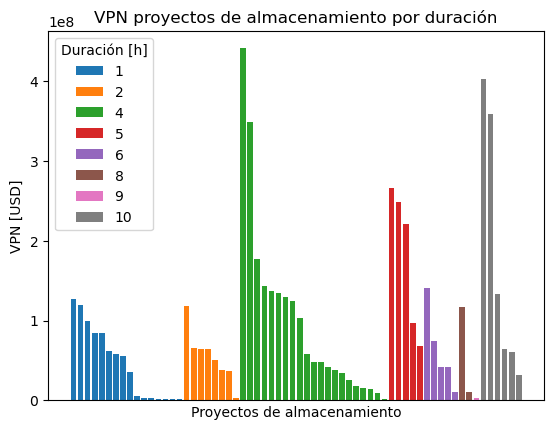

In [362]:
for category, group in npv_df_duration.groupby("duration"):
    plt.bar(
        group["generation_project"],  # X-axis
        group["NPV"],  # Y-axis
        label=category  # Legend label
    )

# Add labels and legend
plt.xticks([])
plt.xlabel("Proyectos de almacenamiento")
plt.ylabel("VPN [USD]")
plt.title("VPN proyectos de almacenamiento por duración")
plt.legend(title="Duración [h]")
plt.show()

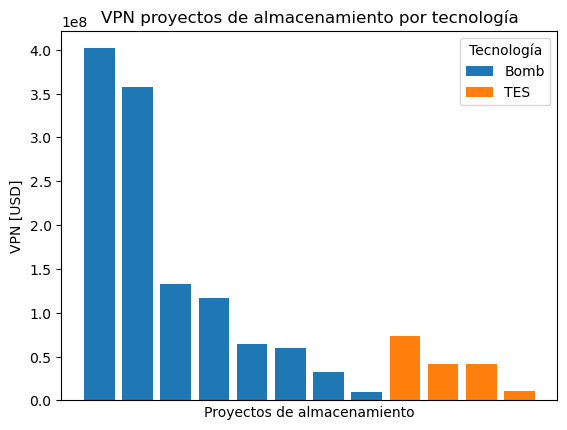

In [363]:
for category, group in npv_df_tech.groupby("tech"):
    plt.bar(
        group["generation_project"],  # X-axis
        group["NPV"],  # Y-axis
        label=category  # Legend label
    )

# Add labels and legend
plt.xticks([])
plt.xlabel("Proyectos de almacenamiento")
plt.ylabel("VPN [USD]")
plt.title("VPN proyectos de almacenamiento por tecnología")
plt.legend(title="Tecnología")
plt.show()

                generation_project               NPV    NPV_energy  \
61        TES_LosChangos220_250_6h    73803274.08652  6.912584e+07   
63        TES_Parinacota220_250_6h   41700293.468566  3.667965e+07   
62  TES_NuevaPozoAlmonte220_250_6h    41299652.83097  3.756577e+07   
60           TES_Lagunas220_250_6h   11097851.751163  1.011370e+07   
29                   Bomb_Arica_8h  116833191.575926  1.558949e+08   
34               Bomb_Tarapaca2_8h    9953825.144302  1.397385e+07   
35               Bomb_Tarapaca_10h  401575426.335392  6.043715e+08   
32               Bomb_Coquimbo_10h  357745978.636526  5.945476e+08   
33              Bomb_Tarapaca2_10h  132600503.423929  1.984178e+08   
30               Bomb_Atacama2_10h   64471065.985921  1.033697e+08   
36             Bomb_Valparaiso_10h   60303521.142733  6.448617e+07   
31                Bomb_Atacama_10h   32179439.263002  3.368110e+07   

       NPV_power  duration  tech  base_year  base_discount_year  \
61  4.987855e+07      

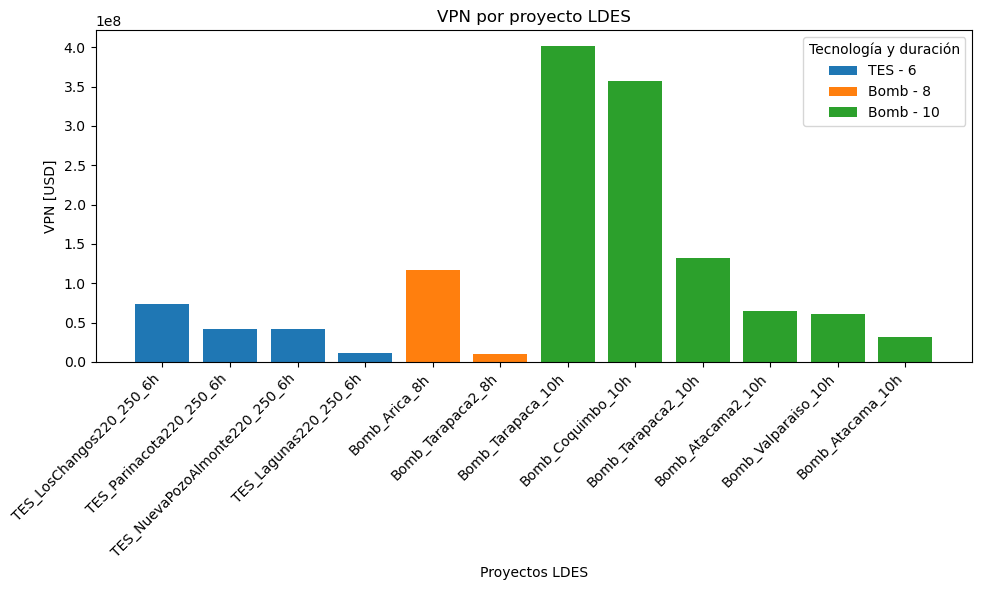

In [364]:
npv_df_tech_dur["group"] = list(zip(npv_df_tech_dur["tech"], npv_df_tech_dur["duration"]))
colors = {group: color for group, color in zip(npv_df_tech_dur["group"].unique(), plt.cm.tab10.colors)}
print(npv_df_tech_dur)
# Plot each row
fig, ax = plt.subplots(figsize=(10, 6))
for _, row in npv_df_tech_dur.iterrows():
    ax.bar(
        row["generation_project"],  # X-axis
        # row["NPV"],
        row["NPV_energy"] + row["NPV_power"] - row["total_cost"],  # Y-axis
        color=colors[row["group"]],  # Color based on group
        label=f"{row["group"][0]} - {row["group"][1]}" if f"{row["group"][0]} - {row["group"][1]}" not in ax.get_legend_handles_labels()[1] else ""
    )

# Customize plot
ax.set_xlabel("Proyectos LDES")
ax.set_ylabel("VPN [USD]")
ax.set_title("VPN por proyecto LDES")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Tecnología y duración")
plt.tight_layout()

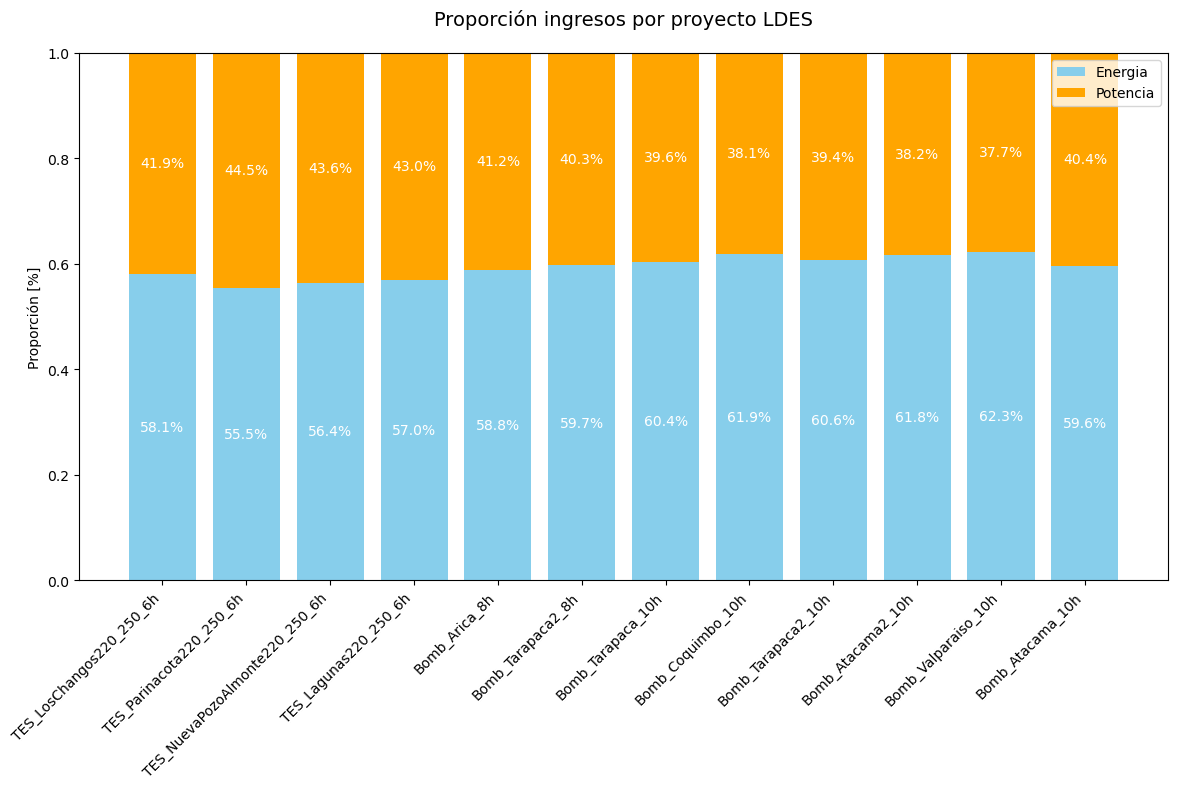

In [365]:
# Calculate total income and proportions
npv_df_tech_dur["total_income"] = npv_df_tech_dur["NPV_energy"] + npv_df_tech_dur["NPV_power"]
npv_df_tech_dur["energy_proportion"] = npv_df_tech_dur["NPV_energy"] / npv_df_tech_dur["total_income"]
npv_df_tech_dur["power_proportion"] = npv_df_tech_dur["NPV_power"] / npv_df_tech_dur["total_income"]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each income's proportion as a stacked bar
ax.bar(
    npv_df_tech_dur["generation_project"],
    npv_df_tech_dur["energy_proportion"],
    label="Energia",
    color="skyblue",
)
ax.bar(
    npv_df_tech_dur["generation_project"],
    npv_df_tech_dur["power_proportion"],
    bottom=npv_df_tech_dur["energy_proportion"],
    label="Potencia",
    color="orange",
)

for i, project in enumerate(npv_df_tech_dur["generation_project"]):
    ax.text(
        i,
        0.5 * npv_df_tech_dur["energy_proportion"].iloc[i],
        f"{npv_df_tech_dur['energy_proportion'].iloc[i]:.1%}",
        ha="center",
        va="center",
        color="white",
    )
    ax.text(
        i,
        npv_df_tech_dur["energy_proportion"].iloc[i] + 0.5 * npv_df_tech_dur["power_proportion"].iloc[i],
        f"{npv_df_tech_dur['power_proportion'].iloc[i]:.1%}",
        ha="center",
        va="center",
        color="white",
    )

# Customize the chart
ax.set_title("Proporción ingresos por proyecto LDES", fontsize=14 ,pad=20)
ax.set_ylabel("Proporción [%]")
ax.set_ylim(0, 1)
ax.legend(loc="upper right")

plt.xticks(rotation=45, ha="right")  # Adjust the angle and alignment
plt.tight_layout()
plt.show()

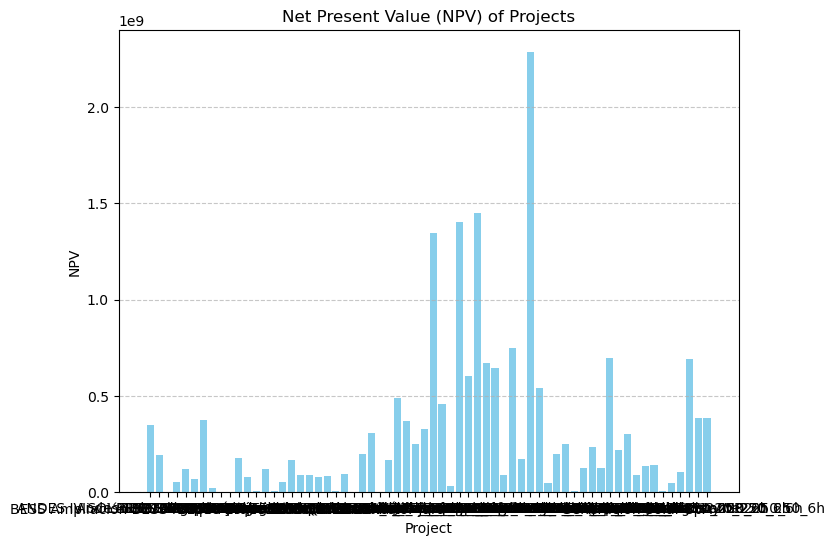

In [366]:
# Step 4: Plot the results
plt.figure(figsize=(8, 6))
plt.bar(npv_df['generation_project'], npv_df['NPV'], color='skyblue')
plt.title('Net Present Value (NPV) of Projects')
plt.xlabel('Project')
plt.ylabel('NPV')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\3749007395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_build_data_filtered["BuildGen"] = gen_build_data_filtered["BuildGen"].astype(float)


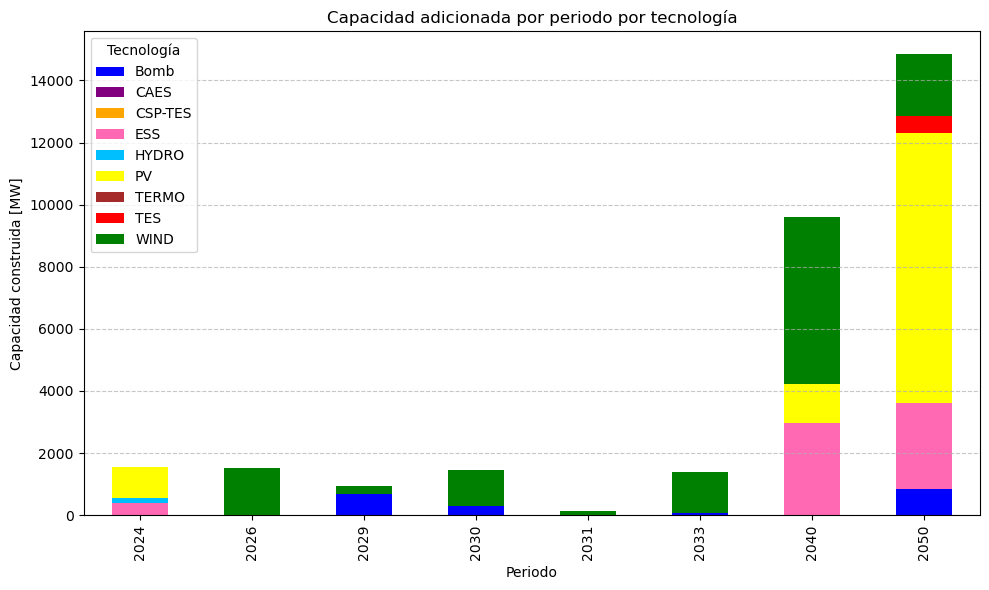

In [367]:
gen_build_data_filtered = gen_build_data[gen_build_data["BuildGen"] != '.']
gen_build_data_filtered["BuildGen"] = gen_build_data_filtered["BuildGen"].astype(float)
# Group by year and technology, summing constructed capacity
grouped_gen_build = gen_build_data_filtered.groupby(['PERIOD', 'gen_tech'])['BuildGen'].sum().reset_index()

# Pivot the data to have years as rows and technologies as columns
pivot_gen_build = grouped_gen_build.pivot(index='PERIOD', columns='gen_tech', values='BuildGen').fillna(0.0)

column_colors = [tech_colors.get(tech, 'gray') for tech in pivot_gen_build.columns]

# Plot
pivot_gen_build.plot(kind='bar', stacked=True, figsize=(10, 6), color=column_colors)
plt.title('Capacidad adicionada por periodo por tecnología')
plt.xlabel('Periodo')
plt.ylabel('Capacidad construida [MW]')
plt.legend(title='Tecnología')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\142577499.py:14: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


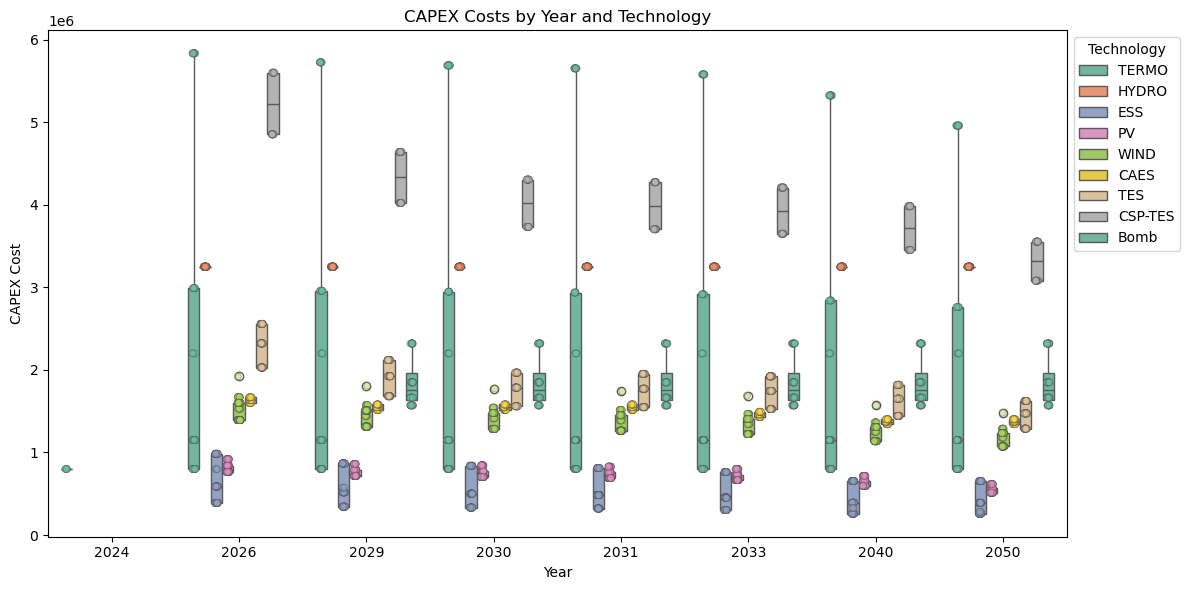

C:\Users\Ignac\AppData\Local\Temp\ipykernel_5484\142577499.py:44: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


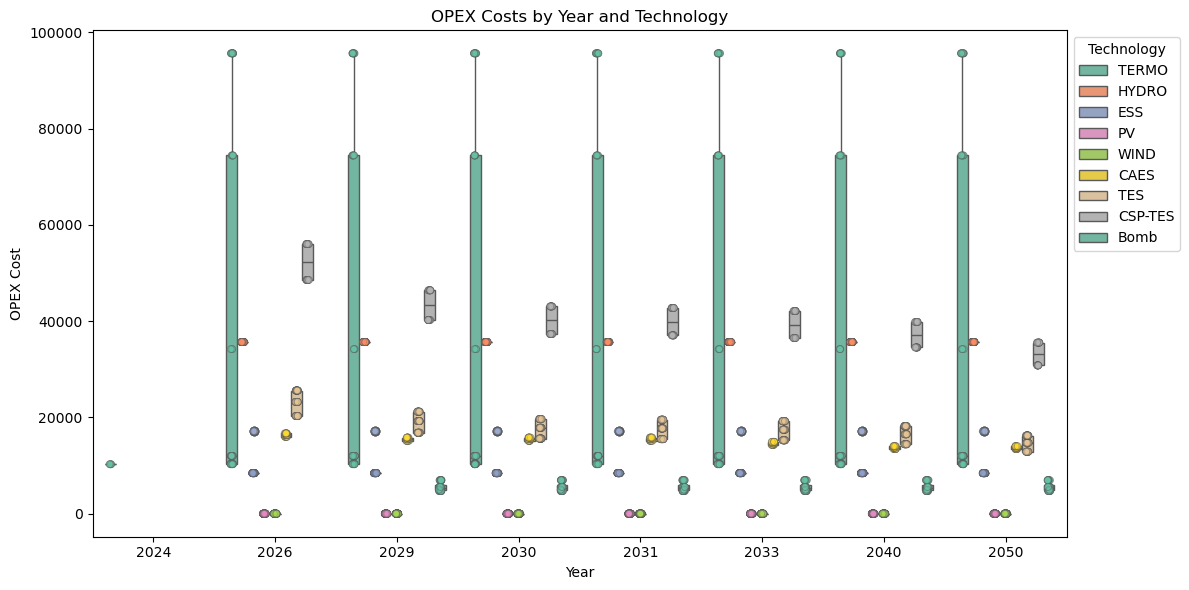

In [368]:
df_merge_cost_build_and_gen_tech = pd.merge(filtered_cost, gen_info_data[["GENERATION_PROJECT", "gen_tech"]], on='GENERATION_PROJECT', how='inner')


# Plot for CAPEX
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_overnight_cost",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
)
sns.stripplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_overnight_cost",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
    alpha=0.5,
    linewidth=0.6,
    edgecolor="gray",
    legend=False,
)

plt.title("CAPEX Costs by Year and Technology")
plt.xlabel("Year")
plt.ylabel("CAPEX Cost")
plt.legend(title="Technology", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot for OPEX
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_fixed_om",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
)
sns.stripplot(
    data=df_merge_cost_build_and_gen_tech,
    x="PERIOD",
    y="gen_fixed_om",
    hue="gen_tech",
    palette="Set2",
    dodge=True,
    alpha=0.5,
    linewidth=0.6,
    edgecolor="gray",
    legend=False,
)

plt.title("OPEX Costs by Year and Technology")
plt.xlabel("Year")
plt.ylabel("OPEX Cost")
plt.legend(title="Technology", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()